In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph

In [30]:
import numpy as np
X = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1],
    [1,0,0],
    [0,1,0]
])
X1 = np.array([
    [1,0,0],
    [1,0,0],
    [0,1,0],
    [1,0,0],
    [0,0,1]
])
A = np.array([
    [1,0.2,0.2,0.2,0.1],
    [0.2,1,0.1,0.2,0.1],
    [0.2,0.1,1,0.2,0.2],
    [0.2,0.2,0.2,1,0.2],
    [0.1,0.1,0.2,0.2,1]
]

)
print(X.shape, A.shape)
print(X.T@A)
print(X.T@A@A)
print(X1.T@A@A)
print(A@A)

(5, 3) (5, 5)
[[1.2 0.4 0.4 1.2 0.3]
 [0.3 1.1 0.3 0.4 1.1]
 [0.2 0.1 1.  0.2 0.2]]
[[1.63 0.95 0.98 1.66 0.78]
 [0.77 1.38 0.77 0.96 1.38]
 [0.48 0.3  1.13 0.5  0.47]]
[[2.1  2.05 1.28 2.14 1.06]
 [0.48 0.3  1.13 0.5  0.47]
 [0.3  0.28 0.47 0.48 1.1 ]]
[[1.13 0.47 0.48 0.5  0.3 ]
 [0.47 1.1  0.3  0.48 0.28]
 [0.48 0.3  1.13 0.5  0.47]
 [0.5  0.48 0.5  1.16 0.48]
 [0.3  0.28 0.47 0.48 1.1 ]]


[3 2 1 3 2 0 0 3 0 1]


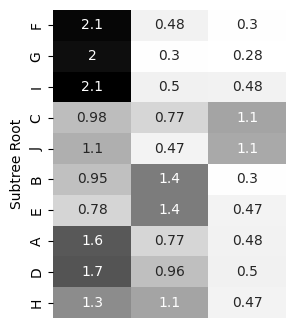

In [46]:
Feature = np.concatenate([(X.T@A@A).T,(X1.T@A@A).T], axis=0)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(Feature)
labels = kmeans.labels_
print(labels)
import seaborn as sns
import matplotlib.pyplot as plt

resort_indices = np.concatenate([
    np.where(labels == 0)[0],
    np.where(labels == 1)[0],
    np.where(labels == 2)[0],
    np.where(labels == 3)[0],
    np.where(labels == 4)[0]
])
f, ax = plt.subplots(figsize=(3,4))
sns.heatmap(Feature[resort_indices], annot=True, cmap = 'Greys', cbar = False)
ax.set(xlabel = '', ylabel = 'Subtree Root')
ax.set_yticklabels(np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])[resort_indices])
ax.get_xaxis().set_visible(False)

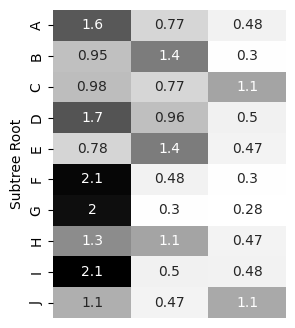

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(3,4))
sns.heatmap(Feature, annot=True, cmap = 'Greys', cbar = False)
ax.set(xlabel = '', ylabel = 'Subtree Root')
ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
ax.get_xaxis().set_visible(False)

TypeError: scatter() got multiple values for argument 's'

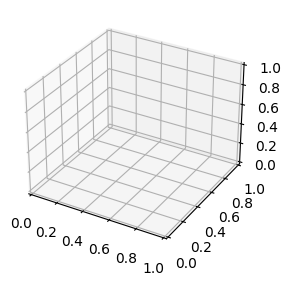

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3,3), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
  *((X.T@A@A).T),
  s = 60
)
ax.scatter(
  *((X1.T@A@A).T),
)

In [16]:
  *((X.T@A@A).T),

(array([1.63, 0.77, 0.48]),
 array([0.95, 1.38, 0.3 ]),
 array([0.98, 0.77, 1.13]),
 array([1.66, 0.96, 0.5 ]),
 array([0.78, 1.38, 0.47]))

# Parameters

In [2]:
iteration = 2
PhenoGraph_k =  100
node_label = 'CellType'
Pattern_ids = [[34, 12, 21, 24, 25, 26]]

# Subset 1

### Clinical

In [3]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical.head()


,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,ERStatus,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust,Clinical Subtype,Subset_id
0,1,MB-0002,2,1.0,84.633333,0.0,83.52,0.0,NO,YES,...,pos,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+,HR+/HER2-,2
1,2,MB-0005,5,1.0,163.700000,1.0,151.28,1.0,YES,NO,...,pos,False,2.0,10-20mm,1,Luminal B,True,IntClust 3,HR+/HER2-,2
2,3,MB-0006,6,1.0,164.933333,0.0,162.76,0.0,YES,YES,...,pos,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9,HR+/HER2-,1
3,5,MB-0010,10,1.0,7.800000,1.0,2.89,1.0,NO,YES,...,pos,False,3.0,20-50mm,0,Luminal B,True,IntClust 7,HR+/HER2-,1
4,6,MB-0014,14,1.0,164.333333,0.0,162.17,0.0,YES,YES,...,pos,False,2.0,5-10mm,1,Luminal B,True,IntClust 3,HR+/HER2-,1


### Histogram

In [5]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + ".pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = Histograms/np.sum(Histograms,axis=1, keepdims=True)

379 patients in total, 243 HR+/HER2-, 16 HR+/HER2+, 16 HR-/HER2+, 50 TNBC
[{'community_id': 1, 'hr': 0.5869052306914894, 'hr_lower': 0.4142459072297528, 'hr_upper': 0.8315296392825532, 'p': 0.0027192401578470093}, {'community_id': 2, 'hr': 1.7293226040065943, 'hr_lower': 0.8444537730650932, 'hr_upper': 3.541409564520504, 'p': 0.13421604462705283}, {'community_id': 3, 'hr': 3.6071384831138724, 'hr_lower': 1.9327203502139831, 'hr_upper': 6.732193840107531, 'p': 5.585215730483297e-05}, {'community_id': 4, 'hr': 1.8065729111156277, 'hr_lower': 1.1490352159688622, 'hr_upper': 2.8403878643744176, 'p': 0.01041662638174559}]
[{'community_id': 3, 'hr': 3.6071384831138724, 'hr_lower': 1.9327203502139831, 'hr_upper': 6.732193840107531, 'p': 5.585215730483297e-05, 'Clinical Subtype': 'HR-/HER2+'}, {'community_id': 4, 'hr': 1.8065729111156277, 'hr_lower': 1.1490352159688622, 'hr_upper': 2.8403878643744176, 'p': 0.01041662638174559, 'Clinical Subtype': 'TNBC'}, {'community_id': 2, 'hr': 1.7293226040

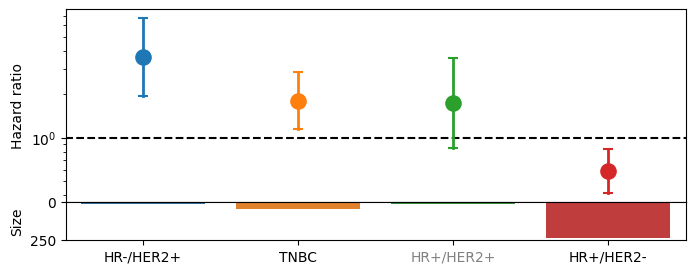

In [6]:
ER_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "ER Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
PR_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "PR Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
HER2_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "HER2 Status"].values[0]
        for patient_id in Patient_IDs
    ]
)

Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
Clinical_subtype_id = np.zeros(Clinical_subtype.shape, dtype=int)
for i in range(len(ER_status)):
    er = ER_status[i]
    pr = PR_status[i]
    her2 = HER2_status[i]
    if (er == "Positive" or pr == "Positive") and her2 == "Negative":
        Clinical_subtype[i] = "HR+/HER2-"
        Clinical_subtype_id[i] = 1
    elif (er == "Positive" or pr == "Positive") and her2 == "Positive":
        Clinical_subtype[i] = "HR+/HER2+"
        Clinical_subtype_id[i] = 2
    elif (er == "Negative" and pr == "Negative") and her2 == "Positive":
        Clinical_subtype[i] = "HR-/HER2+"
        Clinical_subtype_id[i] = 3
    elif (er == "Negative" and pr == "Negative") and her2 == "Negative":
        Clinical_subtype[i] = "TNBC"
        Clinical_subtype_id[i] = 4
print(
    "{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(
        len(Clinical_subtype),
        np.sum(Clinical_subtype == "HR+/HER2-"),
        np.sum(Clinical_subtype == "HR+/HER2+"),
        np.sum(Clinical_subtype == "HR-/HER2+"),
        np.sum(Clinical_subtype == "TNBC"),
    )
)


Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status, "Clinical_subtype_id": Clinical_subtype_id}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
HR = calculate_hazard_ratio(Length_, Status_, Clinical_subtype_id)
print(HR)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
for i in range(len(HR)):
    # print(int(HR['community_id'])-1)
    HR[i]["Clinical Subtype"] = ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'][int(HR[i]['community_id'])-1]
print(HR)

num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['Clinical Subtype']
    print(subgroup_id)
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Clinical_subtype== subgroup_id))
    xticklabels.append(subgroup_id)
    if p < 0.05/len(HR):
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Clinical Subtype")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

In [12]:
Clinical_subtype

array(['HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 0,
       'TNBC', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 0, 0,
       'HR+/HER2+', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'TNBC',
       'HR+/HER2-', 0, 'TNBC', 'TNBC', 'HR+/HER2-', 'TNBC', 'HR+/HER2-',
       'HR+/HER2-', 'TNBC', 'HR+/HER2-', 'TNBC', 'HR+/HER2-', 'HR+/HER2-',
       'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-',
       'TNBC', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'TNBC',
       'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2+',
       'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-',
       'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 0, 'HR+/HER2-', 'HR+/HER2-',
       'HR+/HER2-', 0, 'TNBC', 'TNBC', 'HR+/HER2-', 'HR+/HER2-',
       'HR+/HER2-', 'TNBC', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-',
       'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 'HR+/HER2-', 0, 'HR+/HER2-',
       'HR+/HER2-', 'HR+/HER2-', 'TNBC', 'HR+/HER2-', 'HR+/HER2-

In [4]:
import numpy as np
A = np.array([[1,0.3,0.3,0.3,0.1],
              [0.3,1,0.1,0.3,0.1],
              [0.3,0.1,1,0.3,0.3],
              [0.3,0.3,0.3,1,0.3],
              [0.1,0.1,0.3,0.3,1]])
A@A

array([[1.28, 0.73, 0.75, 0.81, 0.41],
       [0.73, 1.2 , 0.41, 0.75, 0.35],
       [0.75, 0.41, 1.28, 0.81, 0.73],
       [0.81, 0.75, 0.81, 1.36, 0.75],
       [0.41, 0.35, 0.73, 0.75, 1.2 ]])

0 HR+/HER2-
1 HR+/HER2+
2 HR-/HER2+
3 TNBC
4 Unkown


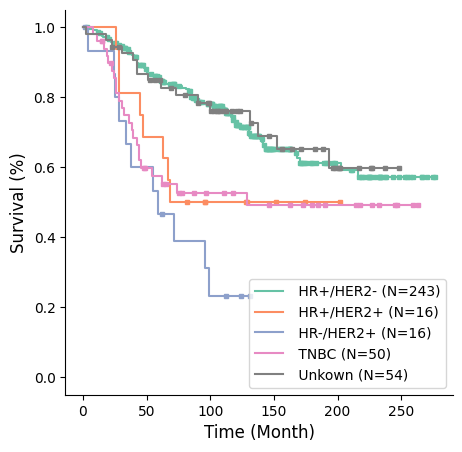

In [15]:
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
color_palette = sns.color_palette("Set2")[:4] +['grey'] 
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5,5))
Clinical_subtype[Clinical_subtype == 0] = "Unkown"
for clinical_subytpe, i in zip(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "Unkown"], range(5)):
    
    print(i,clinical_subytpe)
    length_A, event_observed_A = (
        Length_[Clinical_subtype == clinical_subytpe],
        Status_[Clinical_subtype == clinical_subytpe],
    )
    # print(i,clinical_subtype)
    label = " {} (N={})".format(clinical_subytpe, len(length_A))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[i],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

    # log_rank_test = multivariate_logrank_test(
    #     np.concatenate([length_A, length_B]),
    #     [0] * len(length_A) + [1] * len(length_B),
    #     np.concatenate([event_observed_A, event_observed_B]),
    # )
    # p_value = log_rank_test.p_value
    # ax.legend(fontsize=10)
    # ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
    ylim=(-0.05, 1.05),
)
sns.despine()

### Presentation in 4 clinical subtypes

379 patients in total, 243 HR+/HER2-, 16 HR+/HER2+, 16 HR-/HER2+, 50 TNBC
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.692e-04 U_stat=3.000e+03
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:6.601e-05 U_stat=3.100e+03
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.446e-13 U_stat=1.009e+04
Pattern [34, 12, 21, 24, 25, 26] in HR+/HER2- has 87% of patients
Pattern [34, 12, 21, 24, 25, 26] in HR+/HER2+ has 69% of patients
Pattern [34, 12, 21, 24, 25, 26] in HR-/HER2+ has 44% of patients
Pattern [34, 12, 21, 24, 25, 26] in TNBC has 34% of patients


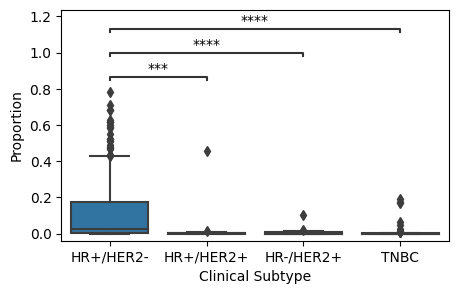

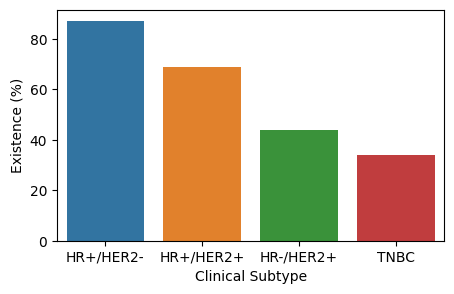

In [37]:
ER_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "ER Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
PR_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "PR Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
HER2_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "HER2 Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er = ER_status[i]
    pr = PR_status[i]
    her2 = HER2_status[i]
    if (er == "Positive" or pr == "Positive") and her2 == "Negative":
        Clinical_subtype[i] = "HR+/HER2-"
    elif (er == "Positive" or pr == "Positive") and her2 == "Positive":
        Clinical_subtype[i] = "HR+/HER2+"
    elif (er == "Negative" and pr == "Negative") and her2 == "Positive":
        Clinical_subtype[i] = "HR-/HER2+"
    elif (er == "Negative" and pr == "Negative") and her2 == "Negative":
        Clinical_subtype[i] = "TNBC"
print(
    "{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(
        len(Clinical_subtype),
        np.sum(Clinical_subtype == "HR+/HER2-"),
        np.sum(Clinical_subtype == "HR+/HER2+"),
        np.sum(Clinical_subtype == "HR-/HER2+"),
        np.sum(Clinical_subtype == "TNBC"),
    )
)

for pattern_id in Pattern_ids:
    histogram = np.sum(Histograms[:, np.array(pattern_id)], axis = 1)
    DF_presentation = pd.DataFrame(
        {
            "Occurence": histogram,
            "Clinical Subtype": Clinical_subtype,
        }
    )
    DF_presentation = DF_presentation.loc[DF_presentation["Clinical Subtype"] != 0]
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(
        x="Clinical Subtype",
        y="Occurence",
        data=DF_presentation,
        showfliers=True,
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
          [("HR+/HER2-", "HR+/HER2+"), ("TNBC", "HR+/HER2-"), ("HR-/HER2+", "HR+/HER2-"),],
        data=DF_presentation,
        x="Clinical Subtype",
        y="Occurence",
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    ax.set_ylabel('Proportion')

    DF_existence = pd.DataFrame(
        {
            "Clinical Subtype": ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
        }
    )
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"]:
        data = DF_presentation.loc[
            DF_presentation["Clinical Subtype"] == clinical_subtype, "Occurence"
        ].values

        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[
            DF_existence["Clinical Subtype"] == clinical_subtype, "Existence (%)"
        ] = (exisitence_ratio * 100)
        print(
            "Pattern {} in {} has {:.0f}% of patients".format(
                pattern_id, clinical_subtype, exisitence_ratio * 100
            )
        )
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(
        x="Clinical Subtype",
        y="Existence (%)",
        data=DF_existence,
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )

### K-M Plot

TypeError: unsupported operand type(s) for -: 'list' and 'int'

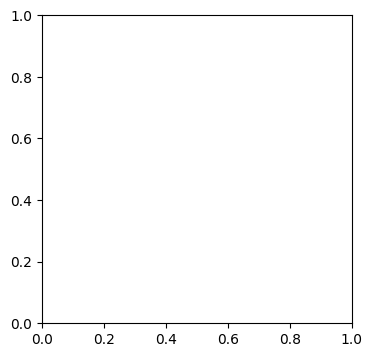

In [10]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="HR+/HER2-"
f, ax = plt.subplots(figsize=(4, 4))
histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
   & (histogram == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
& (histogram == 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )


length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
   
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)

        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )



length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
            & (histogram > 0)
        
        ],
        Status[
            (Clinical_subtype != clinical_subtype)
            & (histogram > 0)
   
        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
            & (histogram == 0)
        
        ],
        Status[
            (Clinical_subtype != clinical_subtype)
            & (histogram == 0)
   
        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    # log_rank_test = multivariate_logrank_test(
    #     np.concatenate([length_A, length_B]),
    #     [0] * len(length_A) + [1] * len(length_B),
    #     np.concatenate([event_observed_A, event_observed_B]),
    # )
    # p_value = log_rank_test.p_value
    # ax.legend(fontsize=10)
    # ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# Subset 2

### Clinical

In [41]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical.head()


,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,ERStatus,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust,Clinical Subtype,Subset_id
0,1,MB-0002,2,1.0,84.633333,0.0,83.52,0.0,NO,YES,...,pos,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+,HR+/HER2-,2
1,2,MB-0005,5,1.0,163.700000,1.0,151.28,1.0,YES,NO,...,pos,False,2.0,10-20mm,1,Luminal B,True,IntClust 3,HR+/HER2-,2
2,3,MB-0006,6,1.0,164.933333,0.0,162.76,0.0,YES,YES,...,pos,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9,HR+/HER2-,1
3,5,MB-0010,10,1.0,7.800000,1.0,2.89,1.0,NO,YES,...,pos,False,3.0,20-50mm,0,Luminal B,True,IntClust 7,HR+/HER2-,1
4,6,MB-0014,14,1.0,164.333333,0.0,162.17,0.0,YES,YES,...,pos,False,2.0,5-10mm,1,Luminal B,True,IntClust 3,HR+/HER2-,1


### Histograms

In [42]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = Histograms/np.sum(Histograms,axis=1, keepdims=True)

### Presentation in 4 clinical subtypes

200 patients in total, 116 HR+/HER2-, 15 HR+/HER2+, 14 HR-/HER2+, 31 TNBC
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:6.158e-04 U_stat=1.343e+03
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:6.278e-06 U_stat=1.412e+03
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.201e-06 U_stat=2.814e+03
Pattern [34, 12, 21, 24, 25, 26] in HR+/HER2- has 85% of patients
Pattern [34, 12, 21, 24, 25, 26] in HR+/HER2+ has 60% of patients
Pattern [34, 12, 21, 24, 25, 26] in HR-/HER2+ has 36% of patients
Pattern [34, 12, 21, 24, 25, 26] in TNBC has 39% of patients


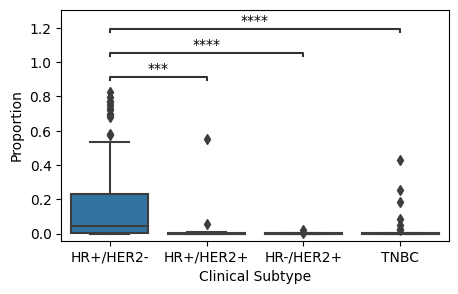

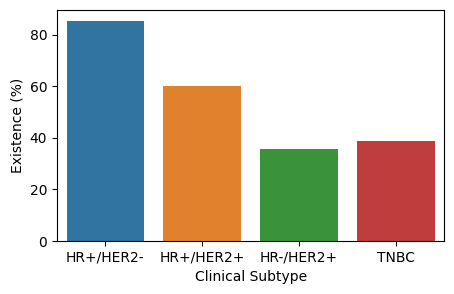

In [43]:
ER_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs])
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs])
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs])
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er= ER_status[i]
    pr= PR_status[i]
    her2= HER2_status[i]
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        Clinical_subtype[i] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        Clinical_subtype[i] = 'TNBC'
print("{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(len(Clinical_subtype),
np.sum(Clinical_subtype == 'HR+/HER2-'), np.sum(Clinical_subtype == 'HR+/HER2+'), np.sum(Clinical_subtype == 'HR-/HER2+'), np.sum(Clinical_subtype == 'TNBC')))

for pattern_id in Pattern_ids:
    histogram = np.sum(Histograms[:, np.array(pattern_id)], axis = 1)
    DF_presentation = pd.DataFrame({
        'Occurence': histogram,
        'Clinical Subtype': Clinical_subtype,
    })
    DF_presentation = DF_presentation.loc[DF_presentation['Clinical Subtype'] != 0]
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x='Clinical Subtype', y='Occurence', data=DF_presentation, showfliers=True, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [("HR+/HER2-", "HR+/HER2+"), ("TNBC", "HR+/HER2-"), ("HR-/HER2+", "HR+/HER2-"),],
        data=DF_presentation,
        x="Clinical Subtype",
        y="Occurence",
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    ax.set(ylabel = 'Proportion')

    DF_existence = pd.DataFrame({
        'Clinical Subtype': ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'],
    })
    for clinical_subtype in ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC']:
        data = DF_presentation.loc[DF_presentation['Clinical Subtype'] == clinical_subtype, 'Occurence'].values
        
        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[DF_existence['Clinical Subtype'] == clinical_subtype, 'Existence (%)'] = exisitence_ratio*100
        print("Pattern {} in {} has {:.0f}% of patients".format(pattern_id, clinical_subtype, exisitence_ratio * 100))
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(x='Clinical Subtype', y='Existence (%)', data=DF_existence, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])

TypeError: unsupported operand type(s) for -: 'list' and 'int'

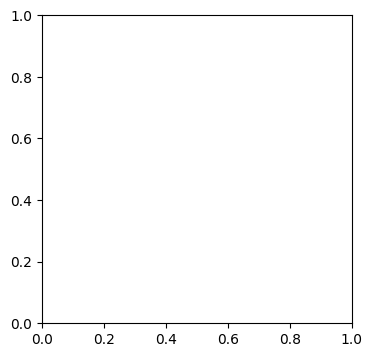

In [14]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="HR+/HER2-"
f, ax = plt.subplots(figsize=(4, 4))
histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
   & (histogram == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
& (histogram == 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )


length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
   
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)

        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )



length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
            & (histogram > 0)
        
        ],
        Status[
            (Clinical_subtype != clinical_subtype)
            & (histogram > 0)
   
        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
            & (histogram == 0)
        
        ],
        Status[
            (Clinical_subtype != clinical_subtype)
            & (histogram == 0)
   
        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    # log_rank_test = multivariate_logrank_test(
    #     np.concatenate([length_A, length_B]),
    #     [0] * len(length_A) + [1] * len(length_B),
    #     np.concatenate([event_observed_A, event_observed_B]),
    # )
    # p_value = log_rank_test.p_value
    # ax.legend(fontsize=10)
    # ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### K-M plot

TypeError: unsupported operand type(s) for -: 'list' and 'int'

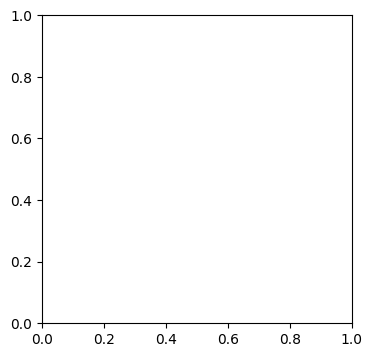

In [15]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="HR+/HER2-"
f, ax = plt.subplots(figsize=(4, 4))
histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )


length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
 
        ],
        Status[
            (Clinical_subtype != clinical_subtype)
  
        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )


    # log_rank_test = multivariate_logrank_test(
    #     np.concatenate([length_A, length_B]),
    #     [0] * len(length_A) + [1] * len(length_B),
    #     np.concatenate([event_observed_A, event_observed_B]),
    # )
    # p_value = log_rank_test.p_value
    # ax.legend(fontsize=10)
    # ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# Jackson

### Clinical

In [38]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical.head()
clinical.rename(columns={'ERStatus': 'ER Status'}, inplace=True)
clinical.rename(columns={'HER2Status': 'HER2 Status'}, inplace=True)
clinical.rename(columns={'PRStatus': 'PR Status'}, inplace=True)
clinical['ER Status'] = clinical['ER Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['HER2 Status'] = clinical['HER2 Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['PR Status'] = clinical['PR Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})

### Histogram

In [39]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = Histograms/np.sum(Histograms,axis=1, keepdims=True)

### Presentation in 4 clinical subtypes

266 patients in total, 173 HR+/HER2-, 25 HR+/HER2+, 22 HR-/HER2+, 45 TNBC
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:3.997e-02 U_stat=2.711e+03
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.560e-03 U_stat=2.652e+03
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.078e-05 U_stat=5.456e+03
Pattern [34, 12, 21, 24, 25, 26] in HR+/HER2- has 82% of patients
Pattern [34, 12, 21, 24, 25, 26] in HR+/HER2+ has 68% of patients
Pattern [34, 12, 21, 24, 25, 26] in HR-/HER2+ has 55% of patients
Pattern [34, 12, 21, 24, 25, 26] in TNBC has 62% of patients


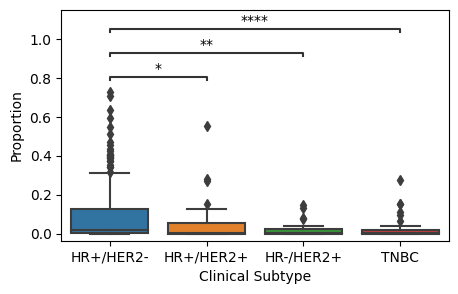

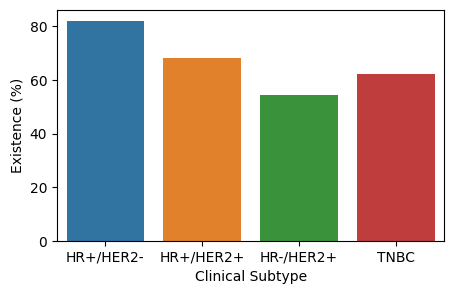

In [40]:

ER_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs])
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs])
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs])
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er= ER_status[i]
    pr= PR_status[i]
    her2= HER2_status[i]
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        Clinical_subtype[i] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        Clinical_subtype[i] = 'TNBC'
print("{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(len(Clinical_subtype),
np.sum(Clinical_subtype == 'HR+/HER2-'), np.sum(Clinical_subtype == 'HR+/HER2+'), np.sum(Clinical_subtype == 'HR-/HER2+'), np.sum(Clinical_subtype == 'TNBC')))

for pattern_id in Pattern_ids:
    histogram = np.sum(Histograms[:, np.array(pattern_id)], axis = 1)
    DF_presentation = pd.DataFrame({
        'Occurence': histogram,
        'Clinical Subtype': Clinical_subtype,
    })
    DF_presentation = DF_presentation.loc[DF_presentation['Clinical Subtype'] != 0]
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x='Clinical Subtype', y='Occurence', data=DF_presentation, showfliers=True, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
       [("HR+/HER2-", "HR+/HER2+"), ("TNBC", "HR+/HER2-"), ("HR-/HER2+", "HR+/HER2-"),],
        data=DF_presentation,
        x="Clinical Subtype",
        y="Occurence",
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    ax.set(ylabel = 'Proportion')

    DF_existence = pd.DataFrame({
        'Clinical Subtype': ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'],
    })
    for clinical_subtype in ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC']:
        data = DF_presentation.loc[DF_presentation['Clinical Subtype'] == clinical_subtype, 'Occurence'].values
        
        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[DF_existence['Clinical Subtype'] == clinical_subtype, 'Existence (%)'] = exisitence_ratio*100
        print("Pattern {} in {} has {:.0f}% of patients".format(pattern_id, clinical_subtype, exisitence_ratio * 100))
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(x='Clinical Subtype', y='Existence (%)', data=DF_existence, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])

### K-M Plot

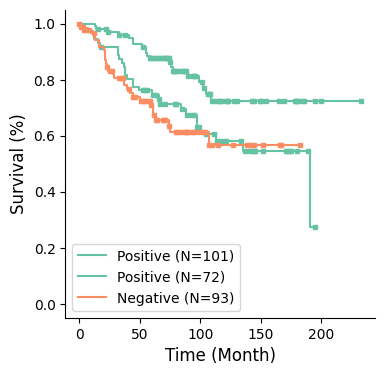

In [23]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="HR+/HER2-"
f, ax = plt.subplots(figsize=(4, 4))
histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )



length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
      
        ],
        Status[
            (Clinical_subtype != clinical_subtype)

        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    # log_rank_test = multivariate_logrank_test(
    #     np.concatenate([length_A, length_B]),
    #     [0] * len(length_A) + [1] * len(length_B),
    #     np.concatenate([event_observed_A, event_observed_B]),
    # )
    # p_value = log_rank_test.p_value
    # ax.legend(fontsize=10)
    # ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()